## Import

In [ ]:
import random
import os
import itertools
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
import tqdm as tq
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import datetime

import re
import time, os
import random
from tqdm import tqdm

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore')

from datetime import datetime, timedelta
from prophet import Prophet #prophet 라이브러리 불러오기

from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed) # Seed 고정

## Load Data

In [ ]:
train_df = pd.read_csv(os.path.abspath("../data")+"/train.csv")
test_df = pd.read_csv(os.path.abspath("../data")+"/test.csv")
buildings = pd.read_csv(os.path.abspath("../data")+"/building_info.csv")

　  1 ~ 15  | 건물기타  
　 16 ~ 23  | 공공  
　 24 ~ 31  | 대학교  
　 32 ~ 36  | 데이터센터  
　 37 ~ 44  | 백화점 및 아울렛  
　 45 ~ 52  | 병원  
　 53 ~ 60  | 상용  
　 61 ~ 68  | 아파트  
　 69 ~ 76  | 연구소  
　 77 ~ 84  | 지식산업센터  
　 85 ~ 92  | 할인마트  
　 93 ~ 100 | 호텔 및 리조트

2022년 08월 25일부터 2022년 08월 31일까지의 전력사용량(kWh)을 예측 (목 ~ 수 7일간)

In [ ]:
lst_공공 = list(range(16,24))

In [ ]:
train_공공 = train_df[train_df['건물번호'].isin(lst_공공)]

In [ ]:
train_공공['일시'] = pd.to_datetime(train_공공['일시'])

In [ ]:
a = pd.DataFrame()

In [ ]:
for i in lst_공공:
    tt = train_공공[train_공공['건물번호']==i]
    tt = tt[['전력소비량(kWh)']].T
    tt.columns = train_공공[train_공공['건물번호']==16]['일시']
    tt.index = [i]
    a = pd.concat([a,tt], axis=0)

In [ ]:
rows_with_high_zeros = a

In [ ]:
train_list = []
test_list = []

In [ ]:
for i in range(len(rows_with_high_zeros)):
    data = rows_with_high_zeros.iloc[i, :].reset_index()  # 6번째 컬럼부터 끝까지 추출
    data.columns = ['date_time', 0]  # 컬럼 이름 변경
    train_list.append(data)

0 번 제품


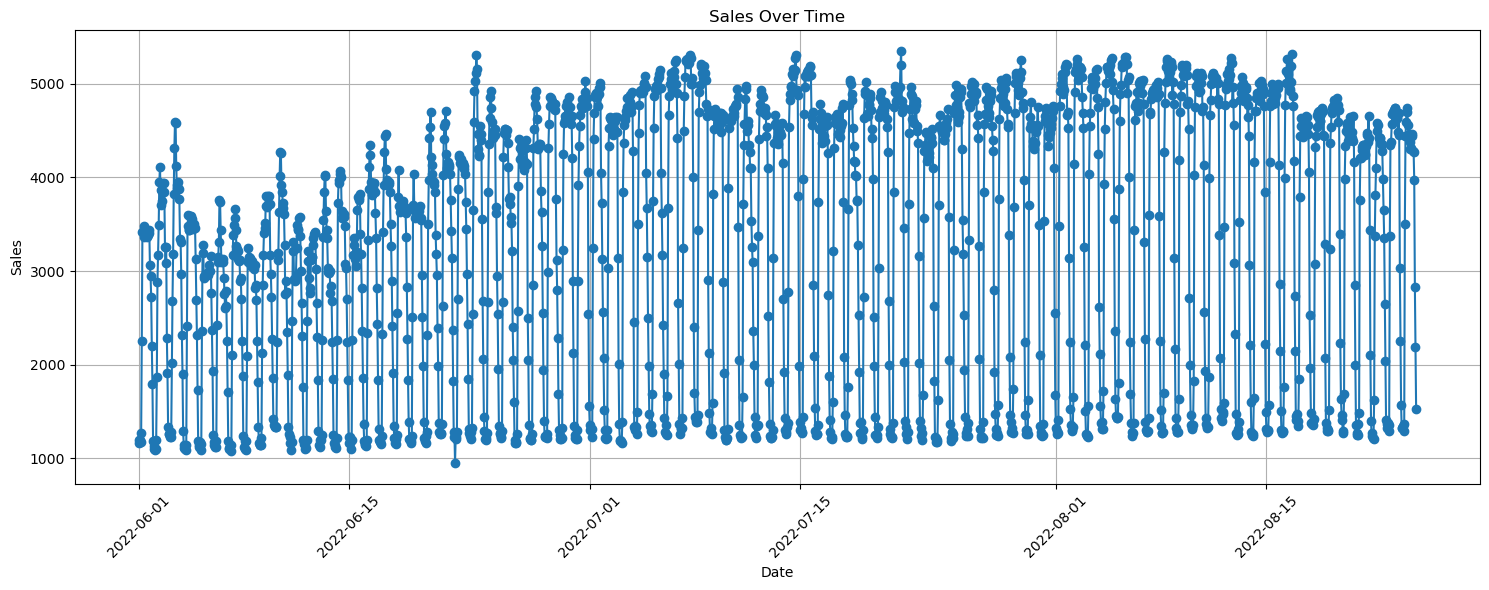

1 번 제품


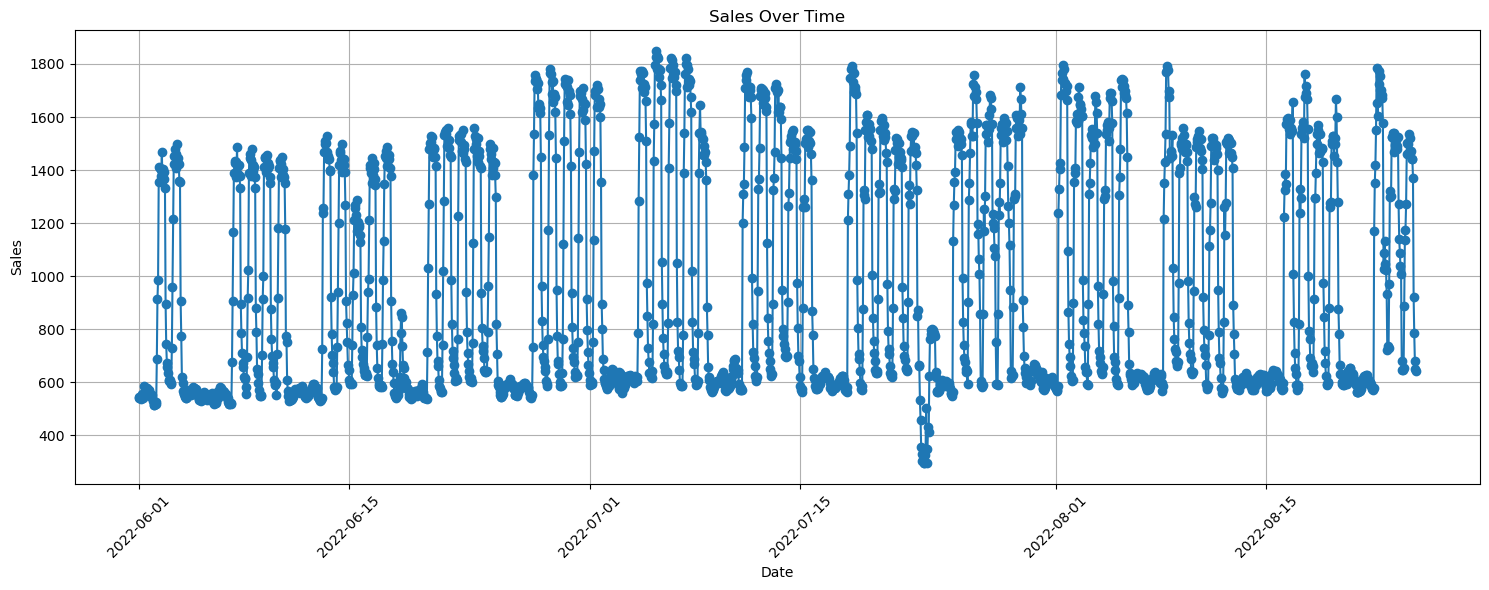

2 번 제품


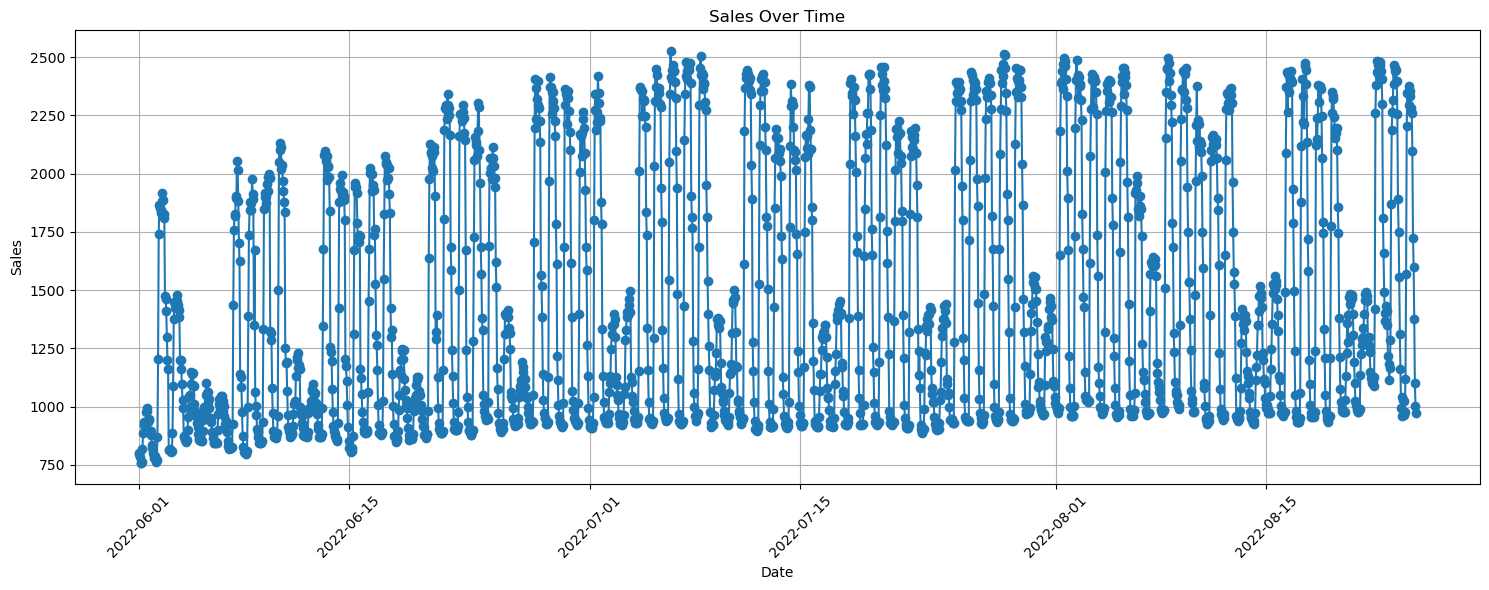

3 번 제품


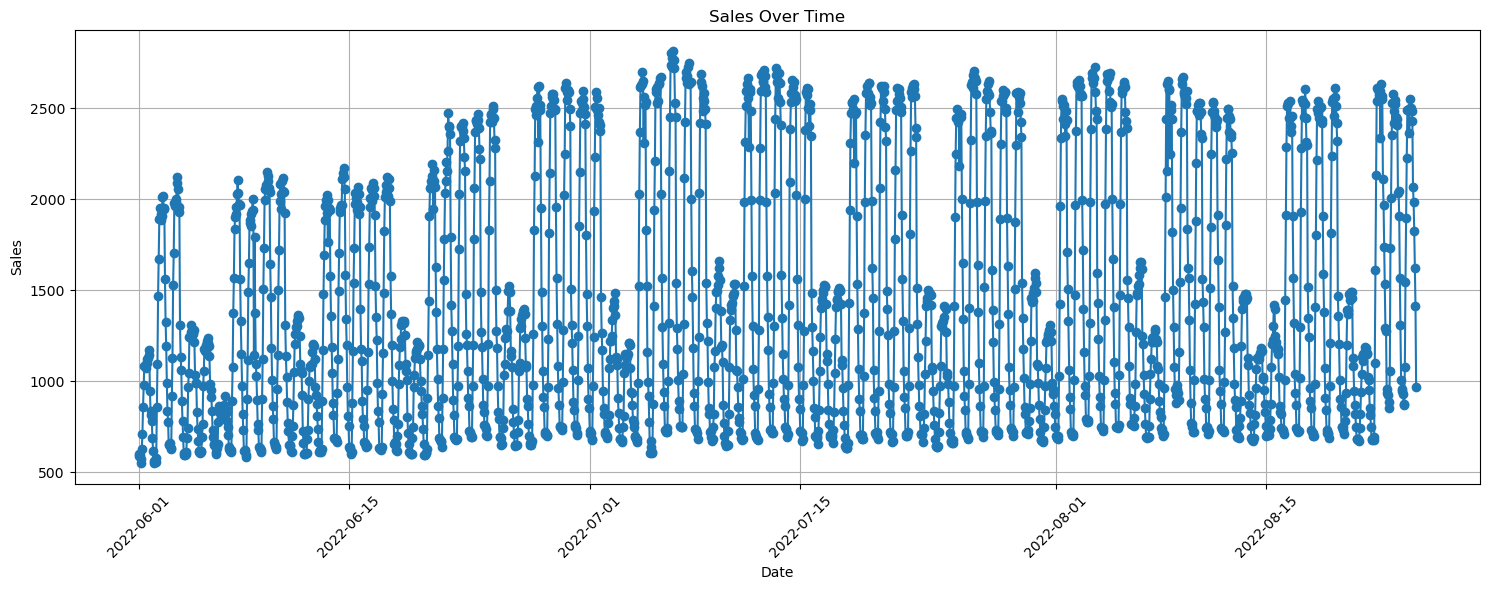

4 번 제품


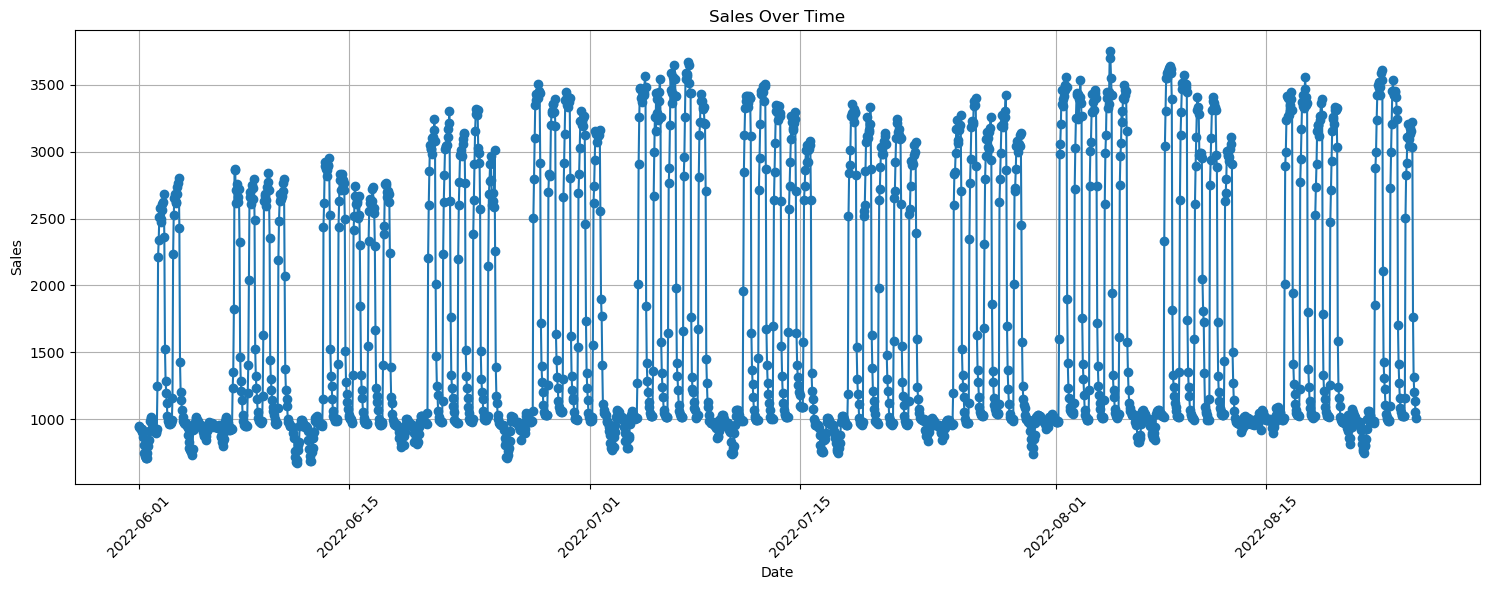

5 번 제품


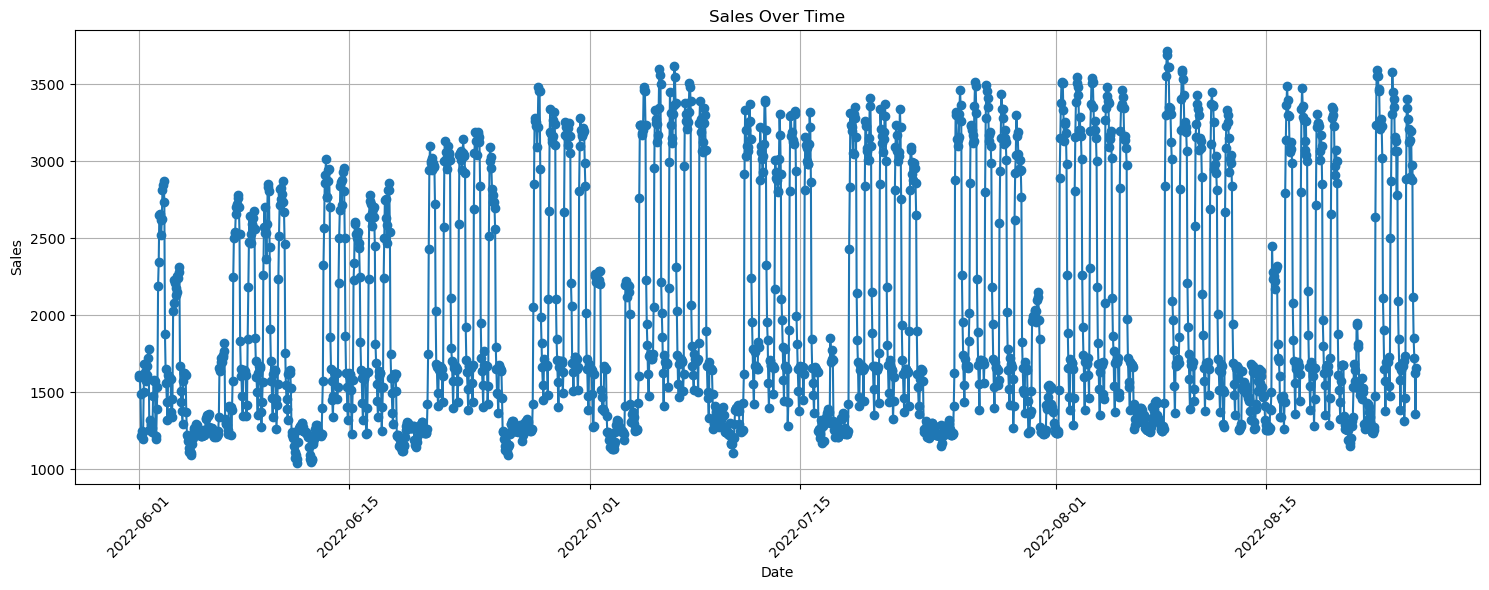

6 번 제품


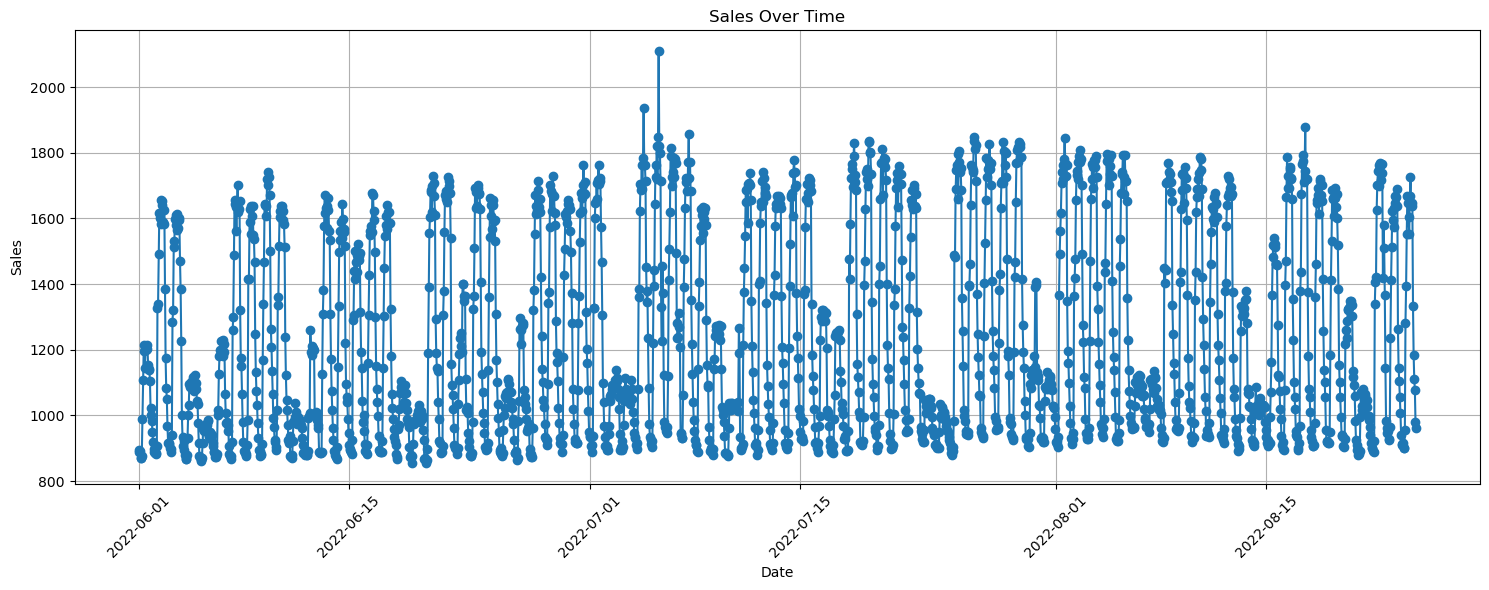

7 번 제품


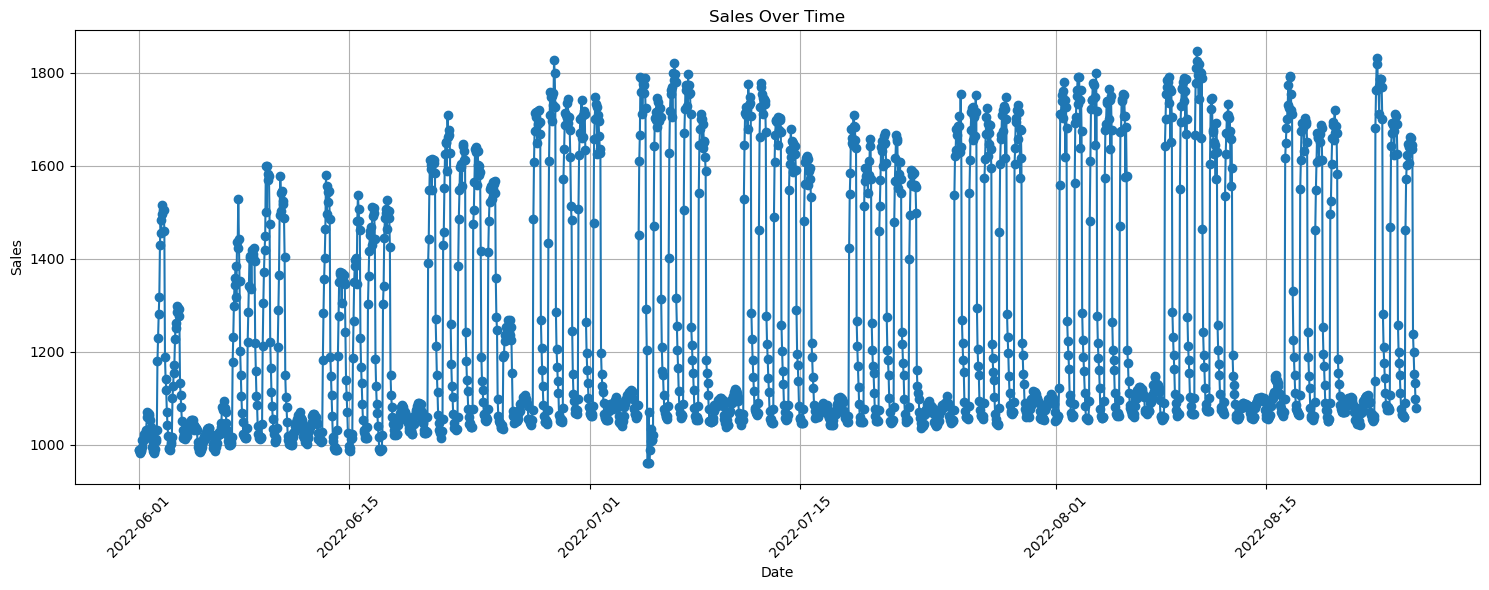

In [ ]:
for i in range(len(rows_with_high_zeros)):
    train_list[i]['date_time'] = pd.to_datetime(train_list[i]['date_time'])
    # 그래프 그리기
    plt.figure(figsize=(15, 6))
    plt.plot(train_list[i]['date_time'], train_list[i][0], marker='o')
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    print(i,"번 제품")
    plt.show()

### ***공공기관은 첫번째 16번 제외 보통 월화수목금 / 토일 으로 주중, 주말의 경향성을 띔을 확인 할 수 있음.***

In [ ]:
start_time = '2022-06-09 00:00:00'
end_time = '2022-08-24 23:00:00'

# 시간 구간에 해당하는 데이터 선택
a = a.loc[:, start_time:end_time]

17번 | 7.23  이상치.  
21번 | 7.1 7.3 7.30 이상치.  
23번 | 6.25 7.4 이상치.


In [ ]:
train_data = a
train_data_T = a.T

In [ ]:
data_lst = []

for i in tqdm(range(len(train_data))):
    # 판매량, 판매가격, 할인율 데이터프레임 생성
    df = pd.DataFrame({'power': train_data_T.iloc[:, i]}).reset_index()

    # 데이터프레임을 리스트에 추가
    data_lst.append(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


***

In [ ]:
import holidays

# 필요한 날짜만큼 생성
date_list = pd.date_range('2022-06-09', '2022-08-31', freq='H')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(date_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')

1it [00:04,  4.09s/it]

0 번째 완료.


2it [00:07,  3.54s/it]

1 번째 완료.


3it [00:10,  3.22s/it]

2 번째 완료.


4it [00:13,  3.21s/it]

3 번째 완료.


5it [00:16,  3.21s/it]

4 번째 완료.


6it [00:19,  3.23s/it]

5 번째 완료.


7it [00:23,  3.25s/it]

6 번째 완료.


8it [00:25,  3.22s/it]

7 번째 완료.


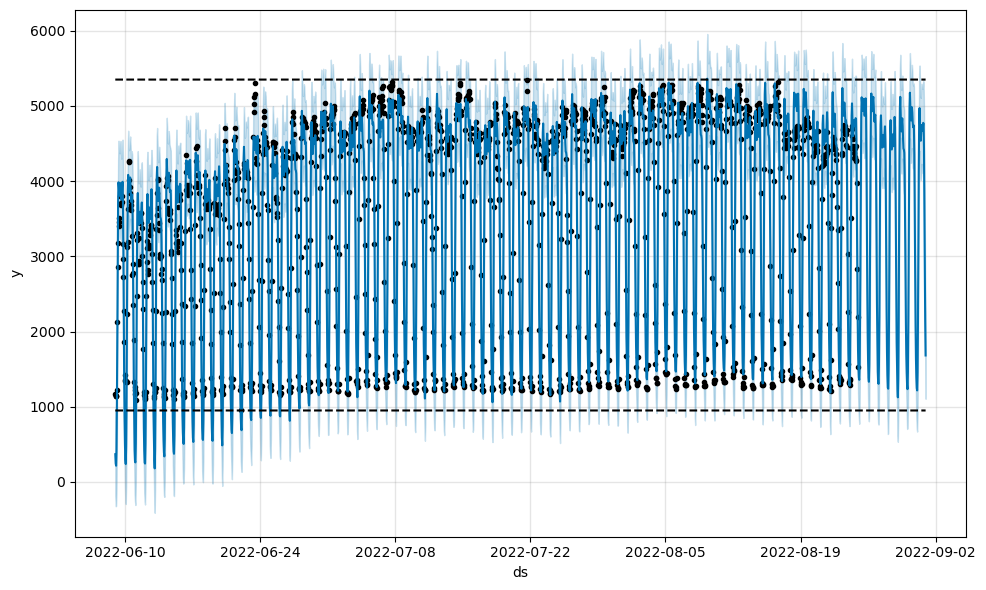

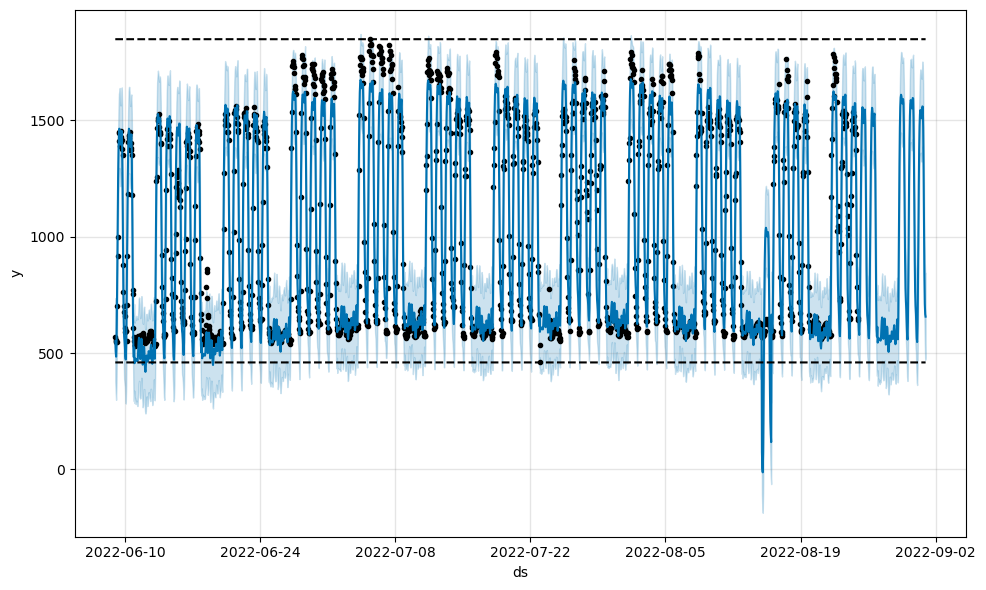

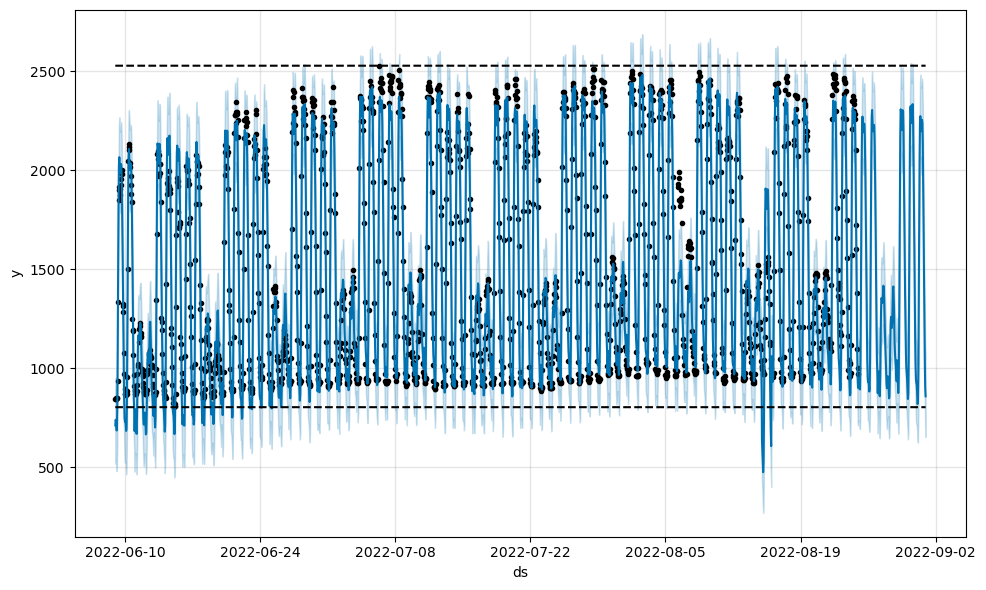

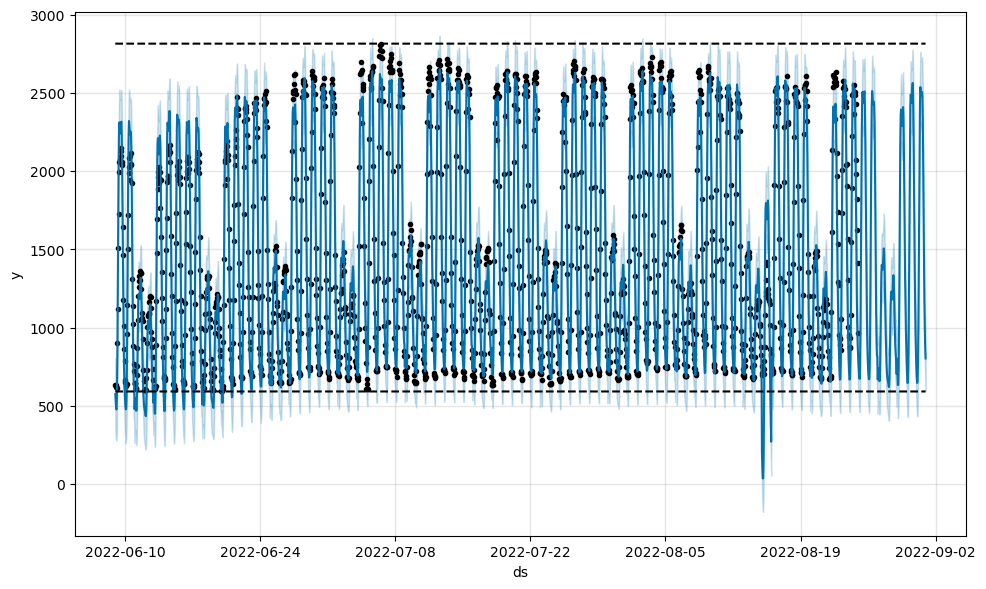

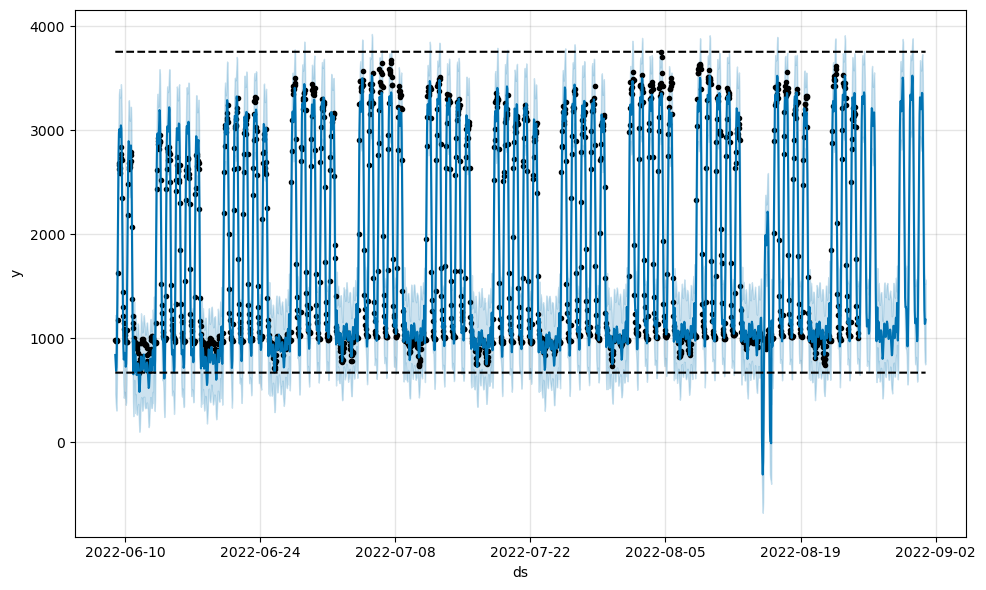

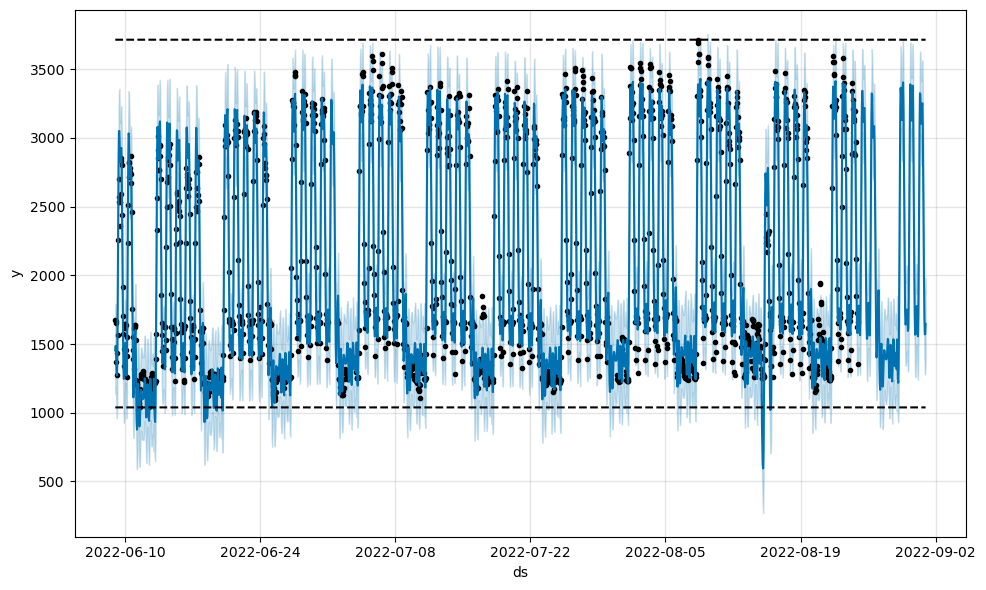

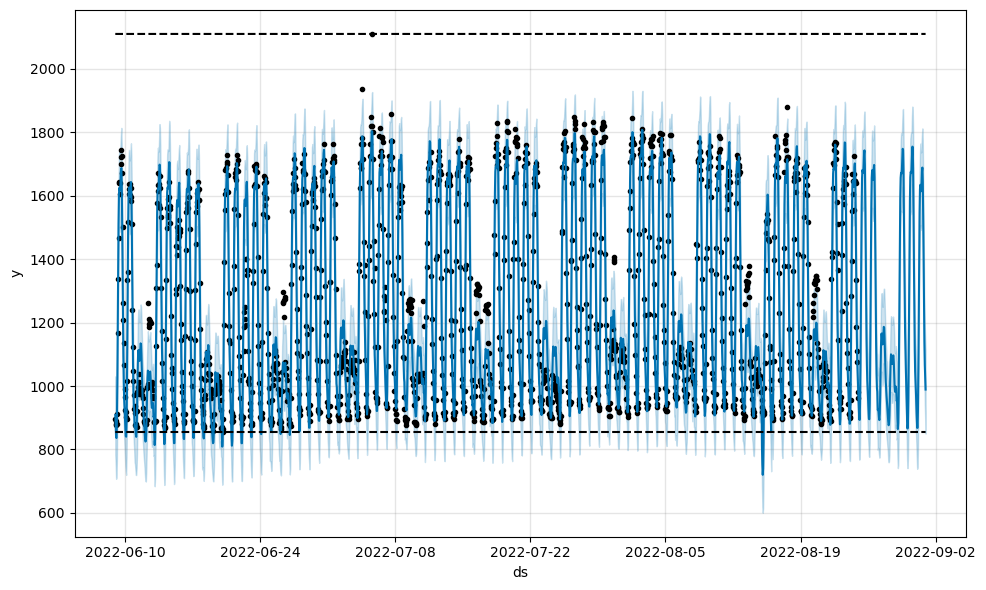

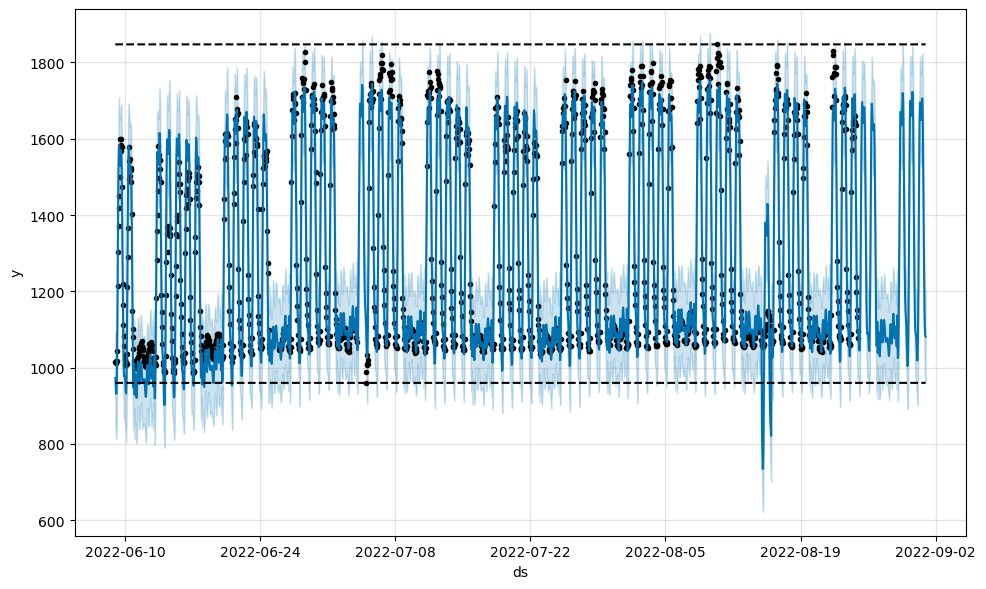

In [ ]:
def make_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 5 or date.weekday() == 6:
        return 1
    else:
        return 0

forecast_공공 = []

for i, value in tqdm(enumerate(lst_공공)):
    import logging

    # 로그 메시지 숨기기
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

    d = pd.DataFrame(data_lst[i]).copy()
    d.columns = ['ds', 'y']
    d['ds'] = pd.to_datetime(d['ds'])
    d['weekend'] = d['ds'].apply(make_weekend)
    d['extra_weight'] = 1.0
    d.loc[d['ds'] >= d['ds'].max() - pd.Timedelta(hours=167), 'extra_weight'] = 1.5


    ###### 이상치 제거 ######
    if value == 17:
        d.loc[(d['ds'] > '2022-07-23 00:00:00') & (d['ds'] < '2022-07-23 23:00:00'), 'y'] = None
    elif value == 21:
        d.loc[(d['ds'] > '2022-07-01 00:00:00') & (d['ds'] < '2022-07-01 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-03 00:00:00') & (d['ds'] < '2022-07-03 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-30 00:00:00') & (d['ds'] < '2022-07-30 23:00:00'), 'y'] = None
    elif value == 23:
        d.loc[(d['ds'] > '2022-06-25 00:00:00') & (d['ds'] < '2022-06-25 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-04 00:00:00') & (d['ds'] < '2022-07-04 23:00:00'), 'y'] = None

    d['cap'] = d['y'].max()
    d['floor'] = d['y'].min()

    _m = Prophet(
        growth='logistic',
        changepoint_prior_scale=0.5,
        yearly_seasonality='auto',
        weekly_seasonality=20,
        daily_seasonality='auto',
        seasonality_mode = 'additive',  # additive or multiplicative
        holidays = holiday_df,
        interval_width=0.9,
               )
    _m.add_regressor('weekend')
    _m.add_regressor('extra_weight')
    _m.fit(d)


    future = _m.make_future_dataframe(periods=168, freq='H')
    future['weekend'] = future['ds'].apply(make_weekend)
    future['extra_weight'] = 1.0
    future['cap'] = d['y'].max()
    future['floor'] = d['y'].min()

    forecast = _m.predict(future)

    forecast_공공.append(forecast['yhat'][-168:])
    fig1 = _m.plot(forecast)

    print(i,'번째 완료.')
    print('=======================')

In [ ]:
submission = pd.read_csv(os.path.abspath("../submission")+"/plus_Prophet_공공.csv")

In [ ]:
t = pd.DataFrame()
for i in range(len(forecast_공공)):
    a = pd.DataFrame(forecast_공공[i])
    t = pd.concat([t,a],axis=0)

In [ ]:
submission['num'] = submission['num_date_time'].str[:-12].astype(int)

In [ ]:
공공_idx = submission[submission['num'].isin(lst_공공)].index

In [ ]:
t.index = 공공_idx

In [ ]:
submission.iloc[공공_idx,1] = t.loc[공공_idx]

In [ ]:
submission = submission[['num_date_time', 'answer']]

In [ ]:
submission.to_csv('../submission/plus_Prophet_공공_ver2.csv', index = False)

Prophet 하이퍼파라미터

In [ ]:
train_data = a
train_data_T = a.T

In [ ]:
data_lst = []

for i in tqdm(range(len(train_data))):
    # 판매량, 판매가격, 할인율 데이터프레임 생성
    df = pd.DataFrame({'power': train_data_T.iloc[:, i]}).reset_index()

    # 데이터프레임을 리스트에 추가
    data_lst.append(df)

100% 8/8 [00:00<00:00, 1524.92it/s]


***

In [ ]:
import holidays

# 필요한 날짜만큼 생성
date_list = pd.date_range('2022-06-09', '2022-08-31', freq='H')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(date_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')

In [ ]:
search_space = {
    'changepoint_prior_scale': [0.05, 0.1, 1.0],
    'seasonality_prior_scale': [0.05, 0.1, 1.0],
    'holidays_prior_scale': [0.1, 0.1, 1.0],
    'seasonality_mode': ['multiplicative'],
    'holidays': [holiday_df]
}

In [ ]:
param_combined = [dict(zip(search_space.keys(), v)) for v in itertools.product(*search_space.values())]

In [ ]:
len(param_combined)

27

In [ ]:
param_lst = []

for i, value in tqdm(enumerate(lst_공공)):
    print(value)

    # 로그 메시지 숨기기
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

    d = data_lst[i].iloc[:,:2].rename(columns={'일시': 'ds', 'power':'y'})

    ###### 이상치 제거 ######
    if value == 17:
        d.loc[(d['ds'] > '2022-07-23 00:00:00') & (d['ds'] < '2022-07-23 23:00:00'), 'y'] = None
    elif value == 21:
        d.loc[(d['ds'] > '2022-07-01 00:00:00') & (d['ds'] < '2022-07-01 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-03 00:00:00') & (d['ds'] < '2022-07-03 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-30 00:00:00') & (d['ds'] < '2022-07-30 23:00:00'), 'y'] = None
    elif value == 23:
        d.loc[(d['ds'] > '2022-06-25 00:00:00') & (d['ds'] < '2022-06-25 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-04 00:00:00') & (d['ds'] < '2022-07-04 23:00:00'), 'y'] = None


    smapes = []
    for j, param in enumerate(param_combined):

        _m = Prophet(**param,
                     daily_seasonality=True,
                     weekly_seasonality=True)
        _m.fit(d)
        _cv_df = cross_validation(_m, initial='28 days', period='7 days', horizon='7 days')#, parallel='threads')
        _cv_df['yhat'] = _cv_df['yhat'].replace(0,0.01)
        _df_p = performance_metrics(_cv_df, rolling_window=1)
        smapes.append(_df_p['smape'].values[0])

    tuning_results = pd.DataFrame(param_combined)
    tuning_results['smapes'] = smapes

    # 'smapes' 컬럼 기준으로 tuning_results 데이터프레임 정렬
    sorted_tuning_results = tuning_results.sort_values(by='smapes')

    param_lst.append({
     'changepoint_prior_scale': sorted_tuning_results.iloc[0,0],
     'seasonality_prior_scale': sorted_tuning_results.iloc[0,1],
     'holidays_prior_scale': sorted_tuning_results.iloc[0,2],
     'seasonality_mode': sorted_tuning_results.iloc[0,3],
     'holidays': sorted_tuning_results.iloc[0,4]
    })

    print(i,'번째 완료.')
    print('=======================')

0it [00:00, ?it/s]

16


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

1it [03:39, 219.41s/it]

0 번째 완료.
17


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

2it [07:07, 212.89s/it]

1 번째 완료.
18


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

3it [10:57, 220.54s/it]

2 번째 완료.
19


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

4it [14:46, 223.77s/it]

3 번째 완료.
20


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

5it [18:18, 219.65s/it]

4 번째 완료.
21


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

6it [21:46, 215.79s/it]

5 번째 완료.
22


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

7it [25:28, 217.84s/it]

6 번째 완료.
23


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

8it [29:03, 217.97s/it]

7 번째 완료.


In [ ]:
with open('param_lst_공공_16_23.pkl', 'wb') as f:
    pickle.dump(param_lst, f)

***

## ***Modeling 공공***

In [ ]:
with open('param_lst_공공_16_23.pkl', 'rb') as f:
    loaded_param_list = pickle.load(f)

In [ ]:
forecast_공공 = []

for i, value in tqdm(enumerate(lst_공공)):
    import logging

    # 로그 메시지 숨기기
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

    d = data_lst[i].iloc[:,:2].rename(columns={'일시': 'ds', 'power':'y'})

    ###### 이상치 제거 ######
    if value == 17:
        d.loc[(d['ds'] > '2022-07-23 00:00:00') & (d['ds'] < '2022-07-23 23:00:00'), 'y'] = None
    elif value == 21:
        d.loc[(d['ds'] > '2022-07-01 00:00:00') & (d['ds'] < '2022-07-01 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-03 00:00:00') & (d['ds'] < '2022-07-03 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-30 00:00:00') & (d['ds'] < '2022-07-30 23:00:00'), 'y'] = None
    elif value == 23:
        d.loc[(d['ds'] > '2022-06-25 00:00:00') & (d['ds'] < '2022-06-25 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-04 00:00:00') & (d['ds'] < '2022-07-04 23:00:00'), 'y'] = None

    _m = Prophet(
        changepoint_prior_scale=loaded_param_list[i]['changepoint_prior_scale'],
        seasonality_prior_scale=loaded_param_list[i]['seasonality_prior_scale'],
        holidays_prior_scale=loaded_param_list[i]['holidays_prior_scale'],
        seasonality_mode=loaded_param_list[i]['seasonality_mode'],
        holidays=loaded_param_list[i]['holidays'],
        daily_seasonality=True,
        weekly_seasonality=True)

    _m.fit(d)

    d['ds'] = pd.to_datetime(d['ds'])

    # 미래 21일에 대한 날짜 범위 생성
    start_date = '2022-08-25 00:00:00'
    end_date = '2022-08-31 23:00:00'
    date_range = pd.date_range(start_date, end_date, freq='H')

    future = pd.DataFrame({'ds': date_range})

    forecast = _m.predict(future)

    forecast_공공.append(round(forecast['yhat']))

    print(i,'번째 완료.')
    print('=======================')

1it [00:01,  1.65s/it]

0 번째 완료.


2it [00:03,  1.90s/it]

1 번째 완료.


3it [00:05,  2.01s/it]

2 번째 완료.


4it [00:08,  2.15s/it]

3 번째 완료.


5it [00:10,  2.23s/it]

4 번째 완료.


6it [00:12,  2.03s/it]

5 번째 완료.


7it [00:13,  1.88s/it]

6 번째 완료.


8it [00:15,  1.94s/it]

7 번째 완료.


1it [00:01,  1.06s/it]

0 번째 완료.


2it [00:02,  1.00it/s]

1 번째 완료.


3it [00:03,  1.03s/it]

2 번째 완료.


4it [00:03,  1.04it/s]

3 번째 완료.


5it [00:04,  1.04it/s]

4 번째 완료.


6it [00:05,  1.01it/s]

5 번째 완료.


7it [00:06,  1.02it/s]

6 번째 완료.


8it [00:07,  1.01it/s]

7 번째 완료.


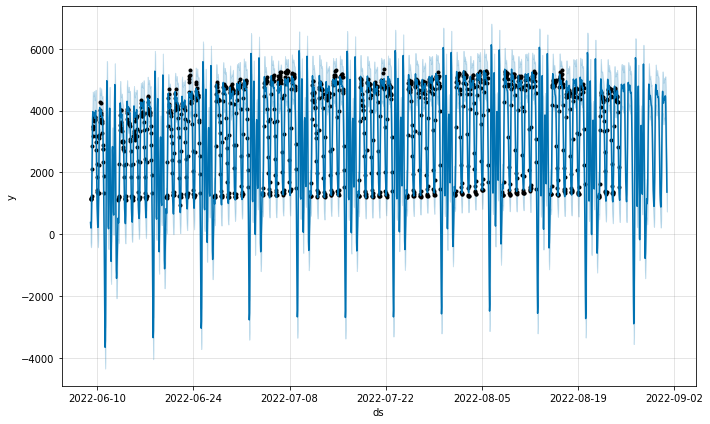

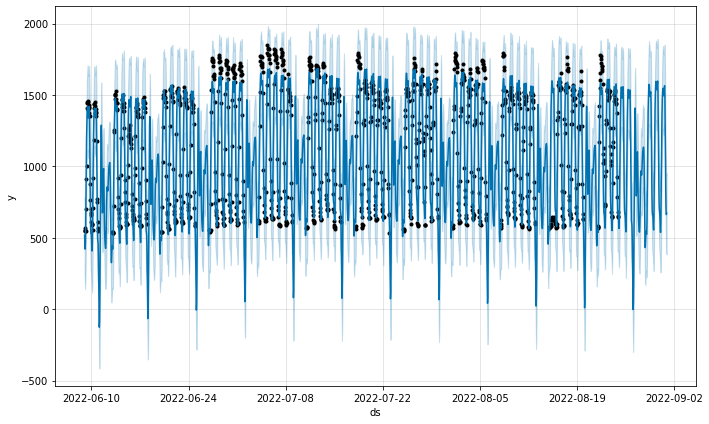

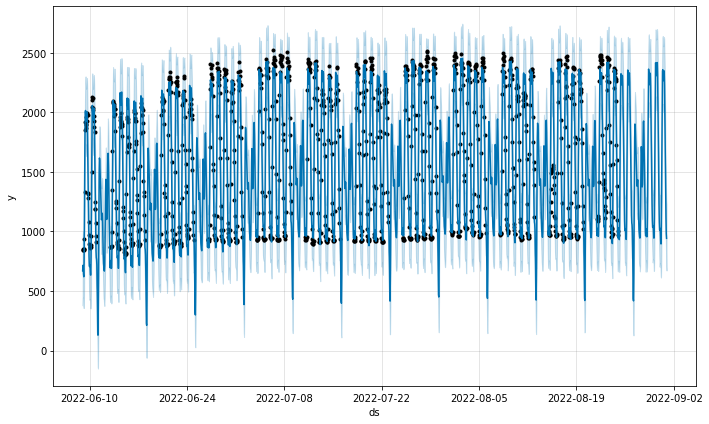

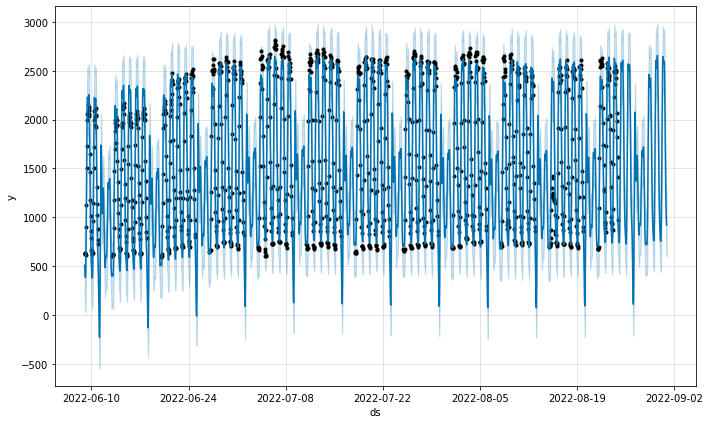

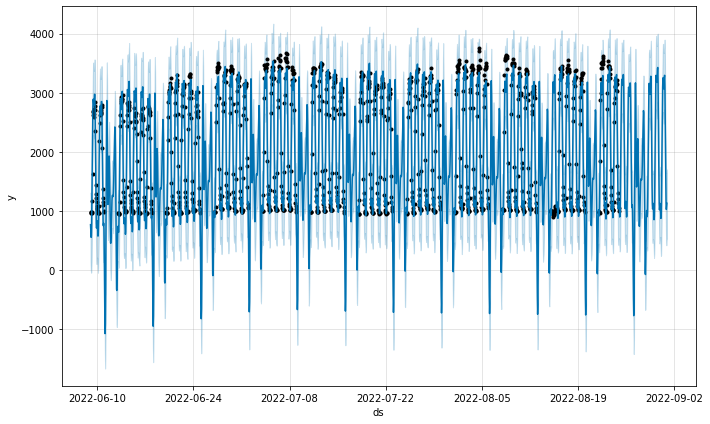

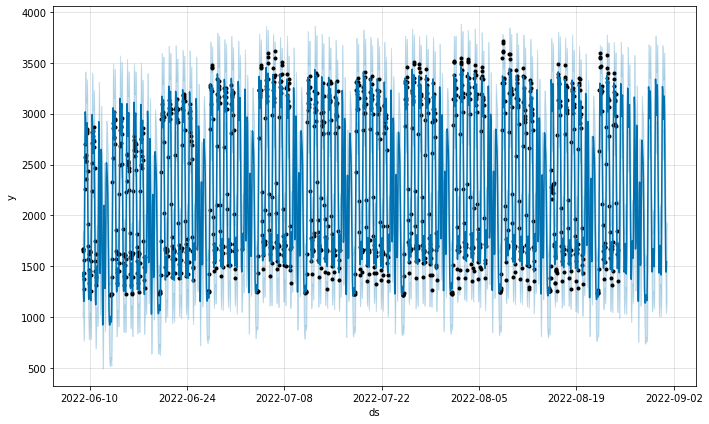

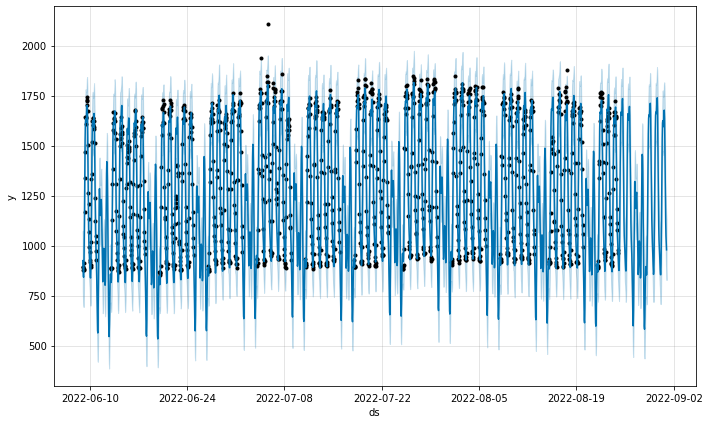

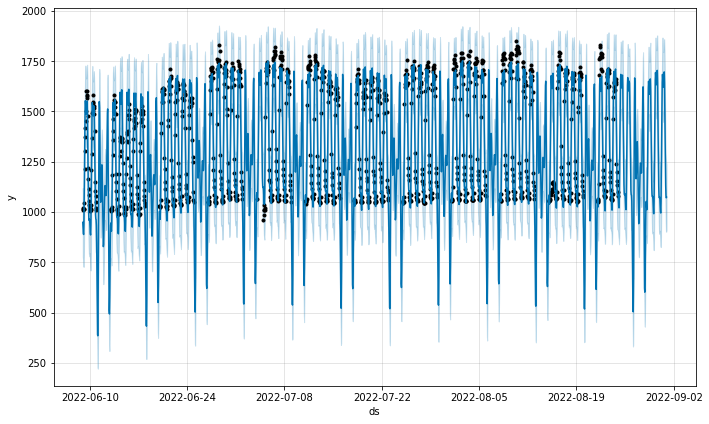

In [ ]:
def make_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 5 or date.weekday() == 6:
        return 1
    else:
        return 0

forecast_공공 = []

for i, value in tqdm(enumerate(lst_공공)):
    import logging

    # 로그 메시지 숨기기
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

    d = pd.DataFrame(data_lst[i]).copy()
    d.columns = ['ds', 'y']
    d['ds'] = pd.to_datetime(d['ds'])
    d['weekend'] = d['ds'].apply(make_weekend)


    ###### 이상치 제거 ######
    if value == 17:
        d.loc[(d['ds'] > '2022-07-23 00:00:00') & (d['ds'] < '2022-07-23 23:00:00'), 'y'] = None
    elif value == 21:
        d.loc[(d['ds'] > '2022-07-01 00:00:00') & (d['ds'] < '2022-07-01 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-03 00:00:00') & (d['ds'] < '2022-07-03 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-30 00:00:00') & (d['ds'] < '2022-07-30 23:00:00'), 'y'] = None
    elif value == 23:
        d.loc[(d['ds'] > '2022-06-25 00:00:00') & (d['ds'] < '2022-06-25 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-04 00:00:00') & (d['ds'] < '2022-07-04 23:00:00'), 'y'] = None

    d.loc[d['weekend'] == 1, 'y'] = None

    _m = Prophet(
                growth='linear',
                weekly_seasonality=20,
                daily_seasonality=True,
                interval_width=0.95
               )
    _m.add_regressor('weekend')
    _m.fit(d)


    future = _m.make_future_dataframe(periods=168, freq='H')
    future['weekend'] = future['ds'].apply(make_weekend)

    forecast = _m.predict(future)

    forecast_공공.append(round(forecast['yhat']))
    fig1 = _m.plot(forecast)

    print(i,'번째 완료.')
    print('=======================')

In [ ]:
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

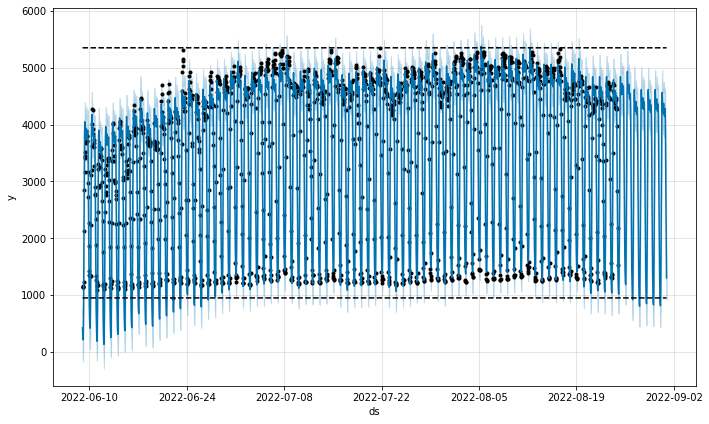

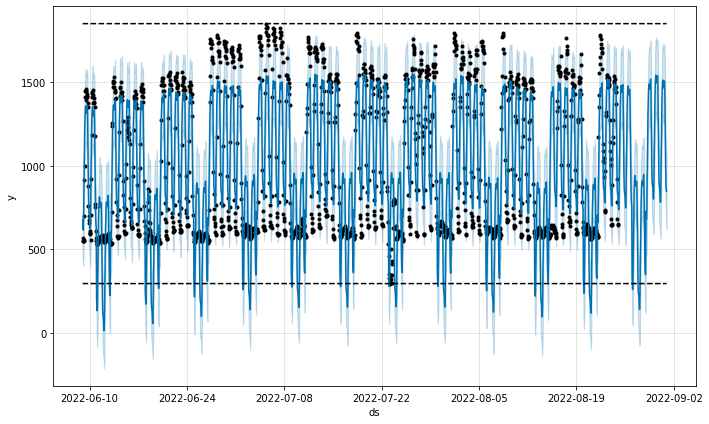

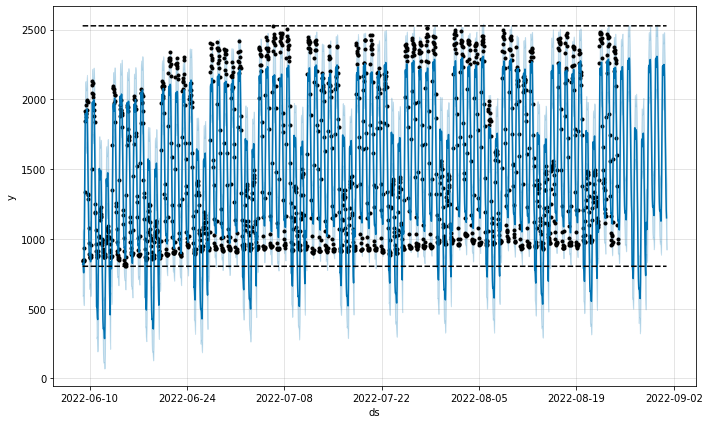

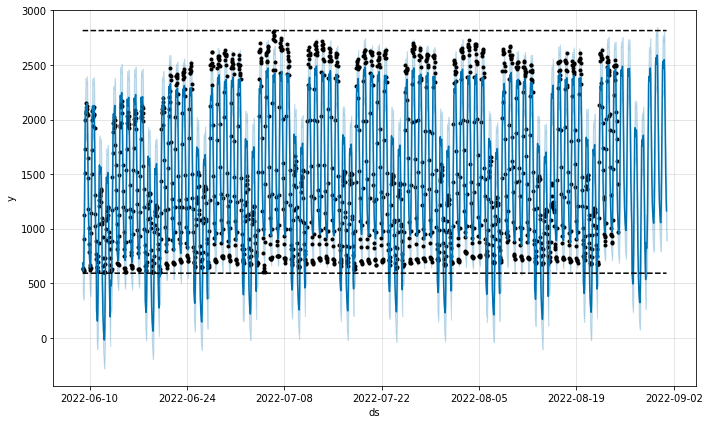

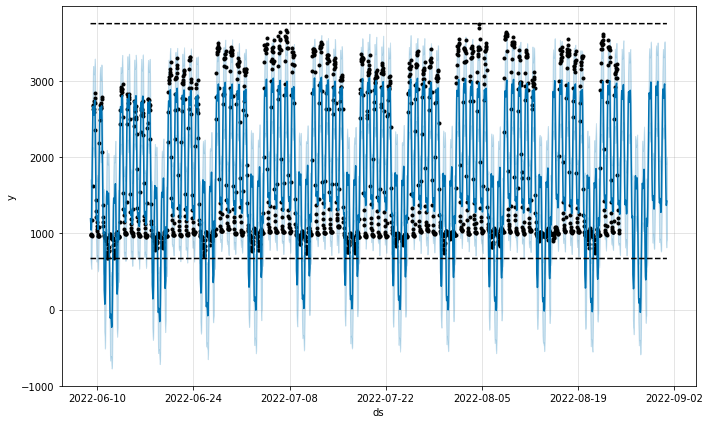

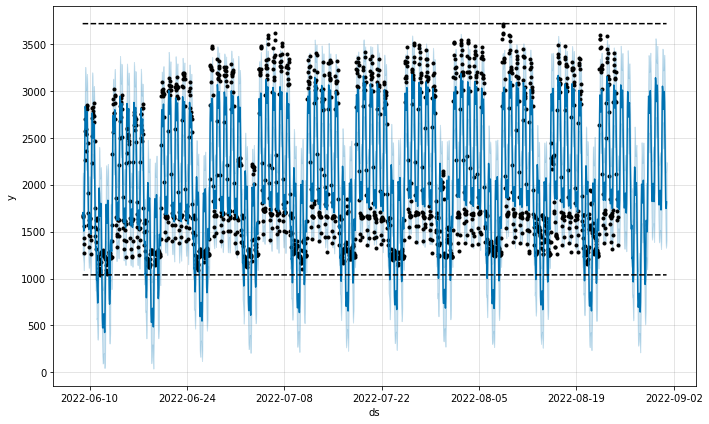

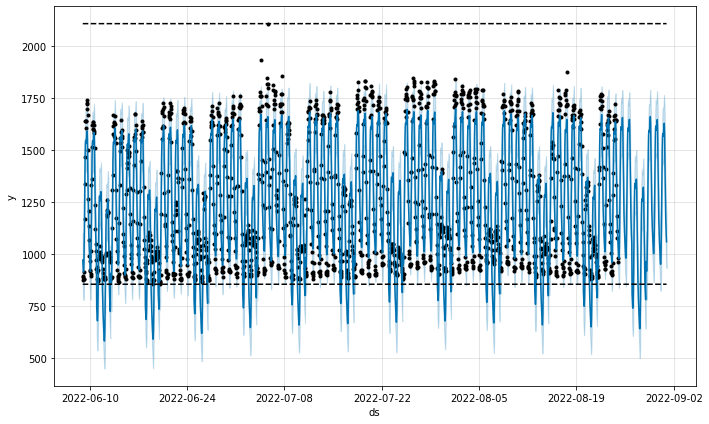

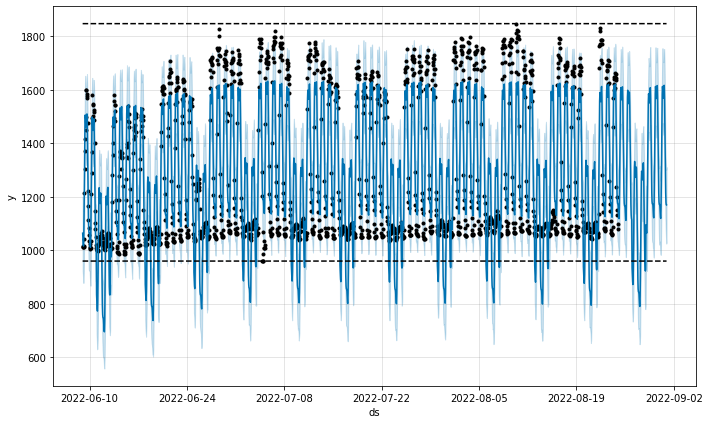

In [ ]:
forecast_list = []

for i in range(len(data_lst)):
    train_1 = pd.DataFrame(data_lst[i]).copy()

    train_1.columns = ['ds', 'y']
    train_1['ds'] = pd.to_datetime(train_1['ds'])
    train_1['weekend'] = train_1['ds'].apply(nfl_sunday)

    weekend_dates = train_1[train_1['weekend'] == 1]['ds'].dt.date

    train_1['cap'] = train_1['y'].max()
    train_1['floor'] = train_1['y'].min()

    m = Prophet(
                growth='logistic',
                changepoint_range=0.7,
                changepoint_prior_scale=0.4,
                changepoints=list(set(weekend_dates.tolist())),
                weekly_seasonality=True,
                daily_seasonality=True,
                interval_width=0.7
               )
    m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
    m.add_regressor('weekend')
    m.fit(train_1)

    future = m.make_future_dataframe(periods=168, freq='H')
    future['cap'] = train_1['y'].max()
    future['floor'] = train_1['y'].min()
    future['weekend'] = future['ds'].apply(nfl_sunday)


    forecast = m.predict(future)

    forecast_list.append(forecast['yhat'])

    fig1 = m.plot(forecast)
#     a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [ ]:
forecast_list = []

for i in range(0,len(data_lst)):
    train_1 = data_lst[i].copy()
    train_1 = pd.DataFrame(train_1)

    train_1.columns = ['ds','y']
    train_1['ds'] = pd.to_datetime(train_1['ds'])

    train_1['cap'] = train_1['y'].max()
    train_1['floor'] = train_1['y'].min()

    m = Prophet(growth='logistic'
               )
    m.history = train_1[['ds', 'y', 'cap', 'floor']].copy()

    m.fit(train_1)

    future = m.make_future_dataframe(periods=168, freq='H')
    future['cap'] = train_1['y'].max()
    future['floor'] = train_1['y'].min()

    forecast = m.predict(future)

    forecast_list.append(forecast['yhat'])

    fig1 = m.plot(forecast)

Exception: Prophet object can only be fit once. Instantiate a new object.

## ***sub***

In [ ]:
submission = pd.read_csv(os.path.abspath("../submission")+"/sample_submission.csv")

In [ ]:
a = pd.DataFrame(forecast_공공[0])

In [ ]:
a

yhat
0    1229.0
1    1059.0
2    1024.0
3    1271.0
4    1931.0
..      ...
163  3931.0
164  3358.0
165  2598.0
166  1902.0
167  1425.0

[168 rows x 1 columns]

In [ ]:
t = pd.DataFrame()
for i in range(len(forecast_공공)):
    a = pd.DataFrame(forecast_공공[i])
    t = pd.concat([t,k],axis=1)

In [ ]:
t

index       0       1       2       3       4       5       6       7  \
0  yhat  1229.0  1059.0  1024.0  1271.0  1931.0  2921.0  3924.0  4583.0   

        8  ...     158     159     160     161     162     163     164  \
0  4757.0  ...  4173.0  4058.0  4038.0  4129.0  4165.0  3931.0  3358.0   

      165     166     167  
0  2598.0  1902.0  1425.0  

[1 rows x 1352 columns]

In [ ]:
t.reset_index(drop=True,inplace=True)
t = np.round(t).astype(int)

In [ ]:
id_lst = t['ID'].tolist()

In [ ]:
t = t.set_index('ID')

In [ ]:
idx_lst = t.index.tolist()

In [ ]:
t = t.replace(0, 1)

In [ ]:
submission.iloc[idx_lst,1:] = t.loc[idx_lst]

In [ ]:
submission.to_csv('../submission/submission_2778+484+__.csv', index = False)

In [ ]:
t = pd.DataFrame()
for i in range(len(forecast_공공)):
    a = pd.DataFrame(forecast_공공[i])
    t = pd.concat([t,k],axis=1)

In [ ]:
확인용_data = train_data.copy()

In [ ]:
start_date = '2022-08-25 00:00:00'
end_date = '2022-08-31 23:00:00'
date_range = pd.date_range(start_date, end_date, freq='H')

In [ ]:
zzz = pd.DataFrame(forecast_공공[2]).T

In [ ]:
zzz.columns = date_range
zzz.index = pd.DataFrame(확인용_data.iloc[2,:]).T.index

In [ ]:
확확 = pd.concat([pd.DataFrame(확인용_data.iloc[2,:]).T, zzz], axis = 1)

In [ ]:
확확

2022-06-09 00:00:00  2022-06-09 01:00:00  2022-06-09 02:00:00  \
18                845.1                844.2                849.0   

    2022-06-09 03:00:00  2022-06-09 04:00:00  2022-06-09 05:00:00  \
18                844.5                848.7                850.2   

    2022-06-09 06:00:00  2022-06-09 07:00:00  2022-06-09 08:00:00  \
18                934.2               1333.8               1847.7   

    2022-06-09 09:00:00  ...  2022-08-31 14:00:00  2022-08-31 15:00:00  \
18               1914.9  ...               2252.0               2246.0   

    2022-08-31 16:00:00  2022-08-31 17:00:00  2022-08-31 18:00:00  \
18               2155.0               1996.0               1807.0   

    2022-08-31 19:00:00  2022-08-31 20:00:00  2022-08-31 21:00:00  \
18               1615.0               1428.0               1258.0   

    2022-08-31 22:00:00  2022-08-31 23:00:00  
18               1131.0               1071.0  

[1 rows x 2016 columns]

In [ ]:
len(lst_공공)

8

In [ ]:
len(forecast_공공)

8

***

In [ ]:
start_time = '2022-08-18 00:00:00'
end_time = '2022-08-24 23:00:00'

# 시간 구간에 해당하는 데이터 선택
a = a.loc[:, start_time:end_time]

In [ ]:
rows_with_high_zeros = a

In [ ]:
train_list = []
test_list = []

In [ ]:
for i in range(len(rows_with_high_zeros)):
    data = rows_with_high_zeros.iloc[i, :].reset_index()  # 6번째 컬럼부터 끝까지 추출
    data.columns = ['date_time', 0]  # 컬럼 이름 변경
    train_list.append(data)

0 번 제품


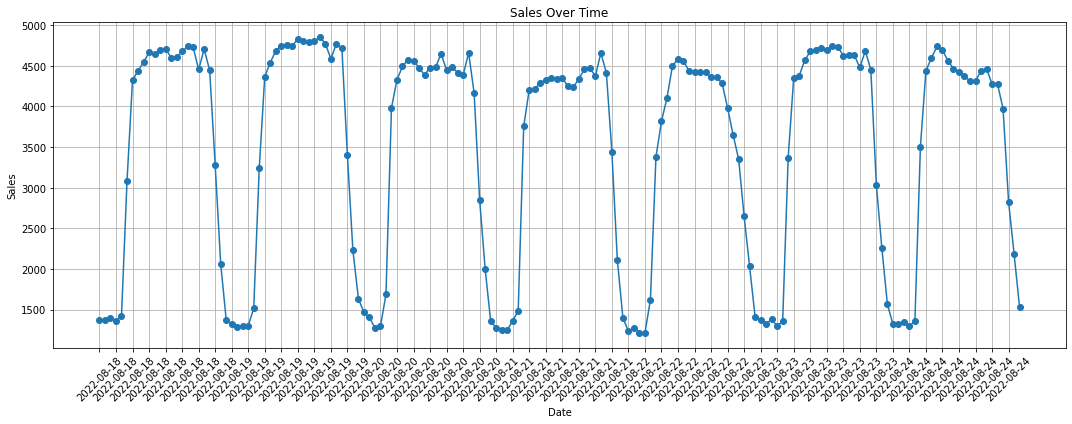

1 번 제품


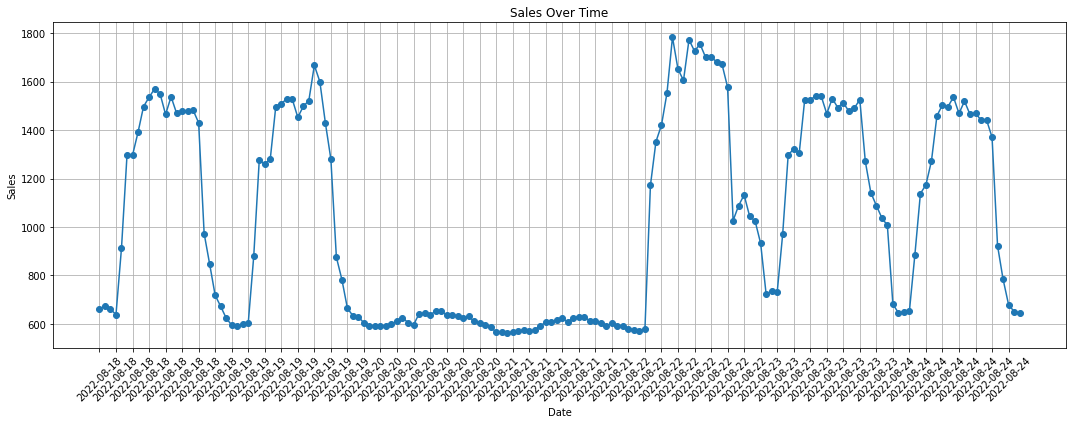

2 번 제품


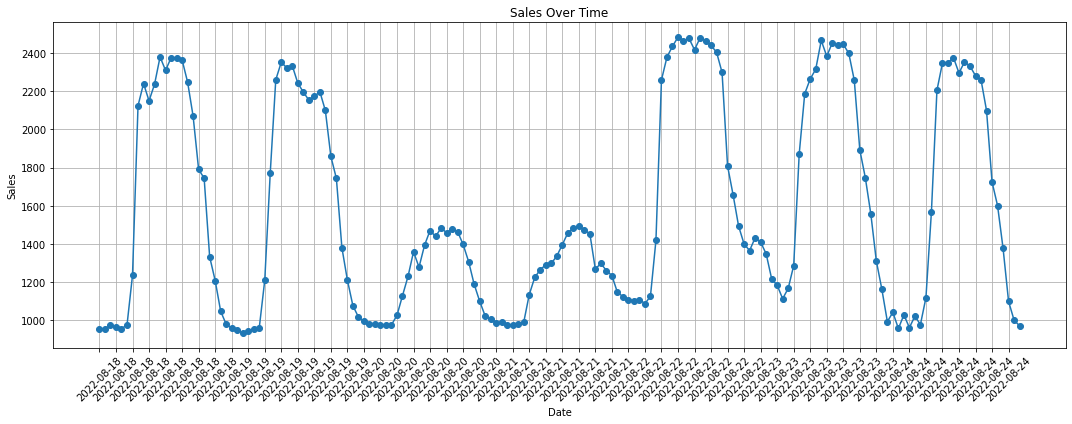

3 번 제품


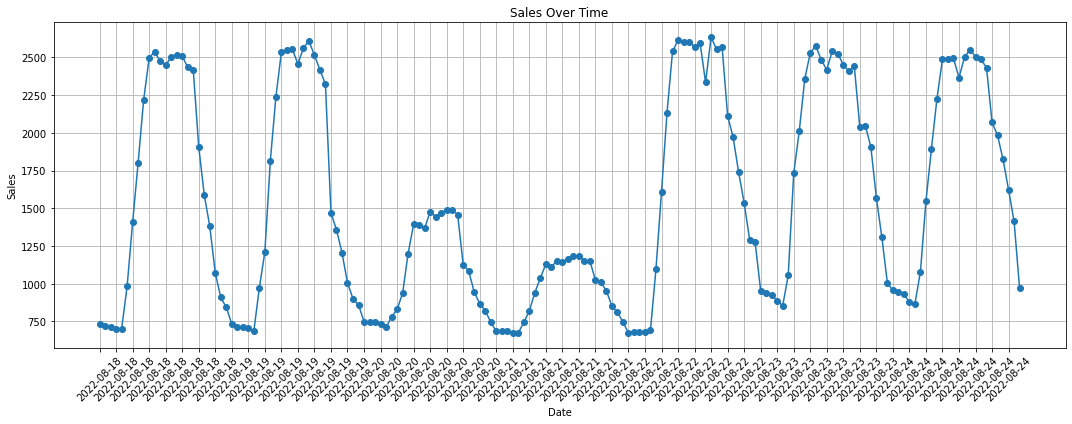

4 번 제품


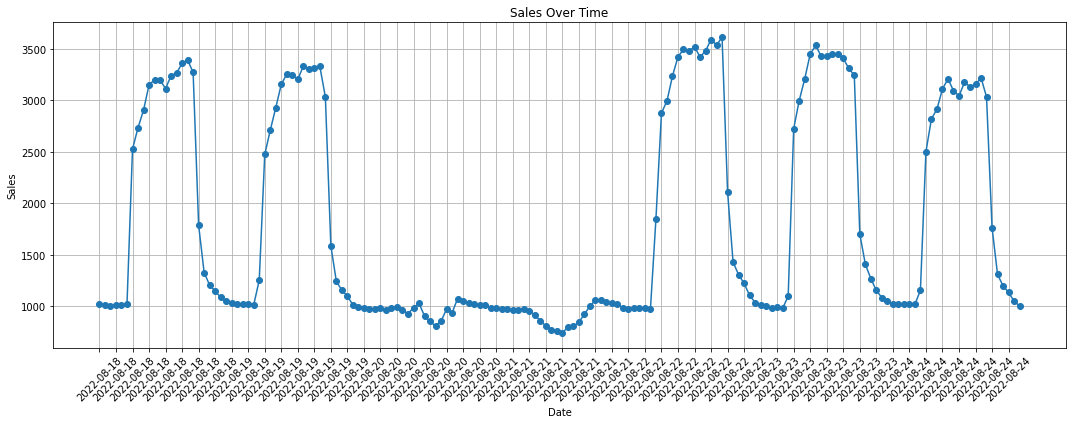

5 번 제품


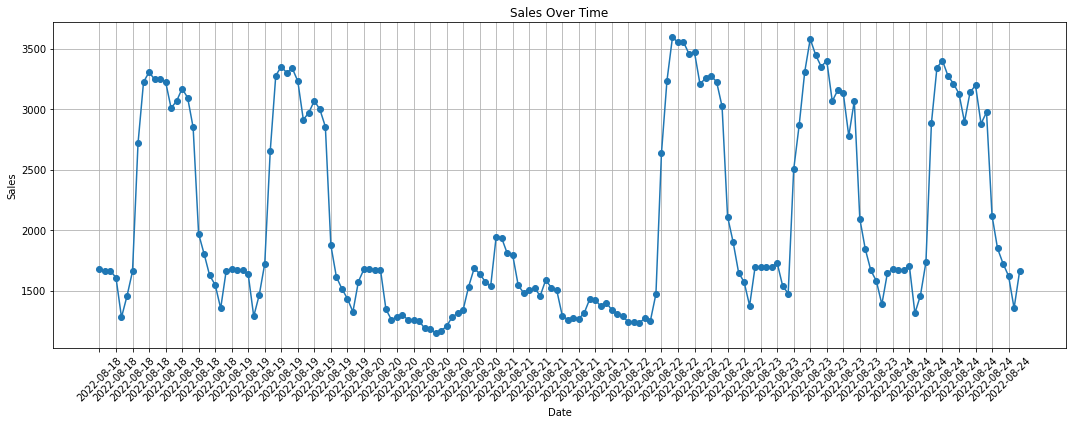

6 번 제품


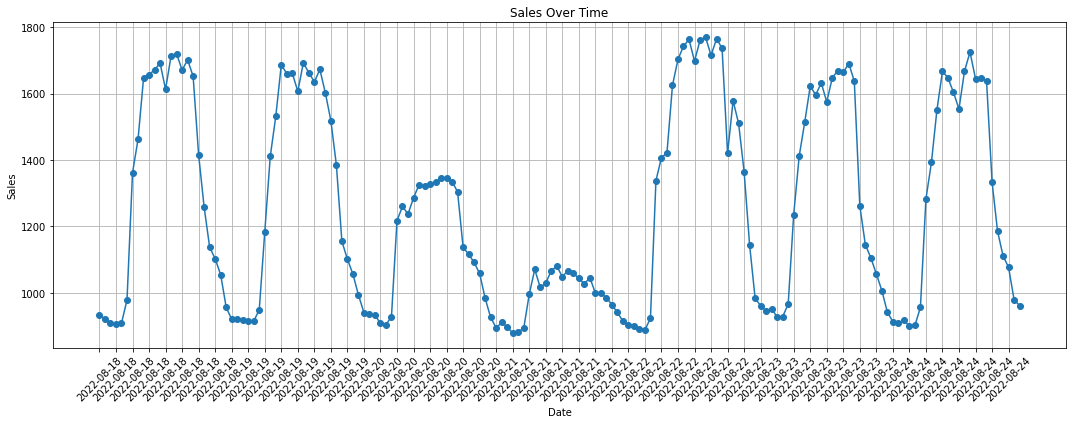

7 번 제품


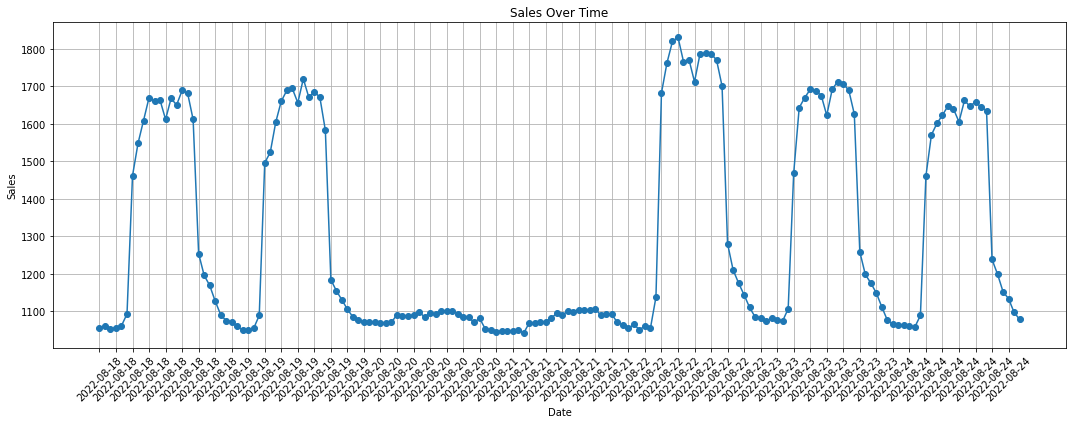

In [ ]:
for i in range(len(rows_with_high_zeros)):
    train_list[i]['date_time'] = pd.to_datetime(train_list[i]['date_time'])
    # 그래프 그리기
    plt.figure(figsize=(15, 6))
    plt.plot(train_list[i]['date_time'], train_list[i][0], marker='o')
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    x_ticks = train_list[i]['date_time'][::3]
    plt.xticks(x_ticks, rotation=45)
    plt.tight_layout()
    print(i,"번 제품")
    plt.show()